# History dependent prediction/ regression models for neural dynamics
- How interaction among neurons give rise to their activity patterns
- Inverstigate the temporal dependence of neural dynamics on the events happening previously
- How far back do previous events influence the activity in the future
- Tease apart the contribution to neural activity from current stimulus and previous activity
- (TODO) Add references
[Posterior parietal cortex represents sensory history and mediates its effects on behaviour](https://www.nature.com/articles/nature25510#:~:text=Earlier%20proposals%20that%20the%20PPC,the%20PPC%20significantly%20improved%20performance.)

### Imports

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)
%matplotlib inline
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# to determine if we can do away with it
import torch 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data: Visual Coding Neuropixel dataset
(TODO) image of task paradigm

In [2]:
# download/ load the data set
output_dir = "/src/swdb_2023/Day5/data"

# this path determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


### Focus on brain observatory data

In [3]:
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
brain_observatory_type_sessions.tail()

published_at  specimen_id           session_type  \
id                                                                    
773418906  2019-10-03T00:00:00Z    757329624  brain_observatory_1.1   
791319847  2019-10-03T00:00:00Z    769360779  brain_observatory_1.1   
797828357  2019-10-03T00:00:00Z    776061251  brain_observatory_1.1   
798911424  2019-10-03T00:00:00Z    775876828  brain_observatory_1.1   
799864342  2019-10-03T00:00:00Z    772616823  brain_observatory_1.1   

           age_in_days sex                                    full_genotype  \
id                                                                            
773418906        124.0   F  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
791319847        116.0   M    Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
797828357        107.0   M  Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
798911424        110.0   F    Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt   
799864342        129.0   M                                            wt/wt   

           unit_count  channel_count  probe_count  \
id                                                  
773418906         546           2232            6   
791319847         555           2229            6   
797828357         611           2232            6   
798911424         825           2233            6   
799864342         604           2233            6   

                                  ecephys_structure_acronyms  
id                                                            
773418906  [PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG...  
791319847  [APN, DG, CA1, VISam, nan, LP, TH, VISpm, POL,...  
797828357  [PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan...  
798911424  [APN, TH, Eth, LP, DG, HPF, CA3, CA1, VISrl, n...  
799864342  [APN, POL, LP, DG, CA1, VISrl, nan, LGd, CA3, ...

### Choose a random session, examine

In [4]:
session_id = 791319847
session = cache.get_session_data(session_id)

In [5]:
# plot number of neurons per region
session.structurewise_unit_counts

VISp     93
CA1      85
VISrl    58
VISl     56
VISam    49
VISal    43
SUB      41
CA3      33
DG       32
VISpm    17
LGv      16
LP        9
LGd       8
TH        4
ZI        4
CA2       3
POL       3
ProS      1
Name: ecephys_structure_acronym, dtype: int64

### Look only at drifting gratings stimulus

In [6]:
session.get_stimulus_table(["drifting_gratings"])

contrast orientation                           phase  \
stimulus_presentation_id                                                        
3798                          0.8        90.0  [5308.98333333, 5308.98333333]   
3799                          0.8       135.0  [5308.98333333, 5308.98333333]   
3800                          0.8       135.0  [5308.98333333, 5308.98333333]   
3801                          0.8         0.0  [5308.98333333, 5308.98333333]   
3802                          0.8       225.0  [5308.98333333, 5308.98333333]   
...                           ...         ...                             ...   
49428                         0.8        90.0  [5308.98333333, 5308.98333333]   
49429                         0.8       270.0  [5308.98333333, 5308.98333333]   
49430                         0.8       270.0  [5308.98333333, 5308.98333333]   
49431                         0.8       180.0  [5308.98333333, 5308.98333333]   
49432                         0.8       180.0  [5308.98333333, 5308.98333333]   

                                    size spatial_frequency   start_time  \
stimulus_presentation_id                                                  
3798                      [250.0, 250.0]              0.04  1590.469172   
3799                      [250.0, 250.0]              0.04  1593.471657   
3800                      [250.0, 250.0]              0.04  1596.474152   
3801                      [250.0, 250.0]              0.04  1599.476677   
3802                      [250.0, 250.0]              0.04  1602.479182   
...                                  ...               ...          ...   
49428                     [250.0, 250.0]              0.04  5388.643497   
49429                     [250.0, 250.0]              0.04  5391.646002   
49430                     [250.0, 250.0]              0.04  5394.648527   
49431                     [250.0, 250.0]              0.04  5397.651052   
49432                     [250.0, 250.0]              0.04  5400.653537   

                         stimulus_block      stimulus_name    stop_time  \
stimulus_presentation_id                                                  
3798                                2.0  drifting_gratings  1592.470862   
3799                                2.0  drifting_gratings  1595.473327   
3800                                2.0  drifting_gratings  1598.475832   
3801                                2.0  drifting_gratings  1601.478347   
3802                                2.0  drifting_gratings  1604.480862   
...                                 ...                ...          ...   
49428                               7.0  drifting_gratings  5390.645187   
49429                               7.0  drifting_gratings  5393.647682   
49430                               7.0  drifting_gratings  5396.650207   
49431                               7.0  drifting_gratings  5399.652682   
49432                               7.0  drifting_gratings  5402.655217   

                         temporal_frequency  duration  stimulus_condition_id  
stimulus_presentation_id                                                      
3798                                   15.0   2.00169                    246  
3799                                    4.0   2.00167                    247  
3800                                    2.0   2.00168                    248  
3801                                    1.0   2.00167                    249  
3802                                    1.0   2.00168                    250  
...                                     ...       ...                    ...  
49428                                   1.0   2.00169                    259  
49429                                   4.0   2.00168                    270  
49430                                   4.0   2.00168                    270  
49431                                   8.0   2.00163                    261  
49432                                   1.0   2.00168                  

### Load spike data, time align to stim onset

In [7]:
presentations = session.get_stimulus_table("drifting_gratings")
# filter out "null trials"
presentations = presentations[presentations.orientation != 'null']
units = session.units[session.units["ecephys_structure_acronym"] == 'VISp']

time_step = 0.05
time_bins = np.arange(-0.1, 0.5 + time_step, time_step)

histograms = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=units.index.values
)

# grab distinct orientations (directions)
unique_orientations = presentations.orientation.unique()
unique_orientations.sort()

### Plot firing rate of each VISp neuron (averaged across stim presentations), aligned on stimulus onset

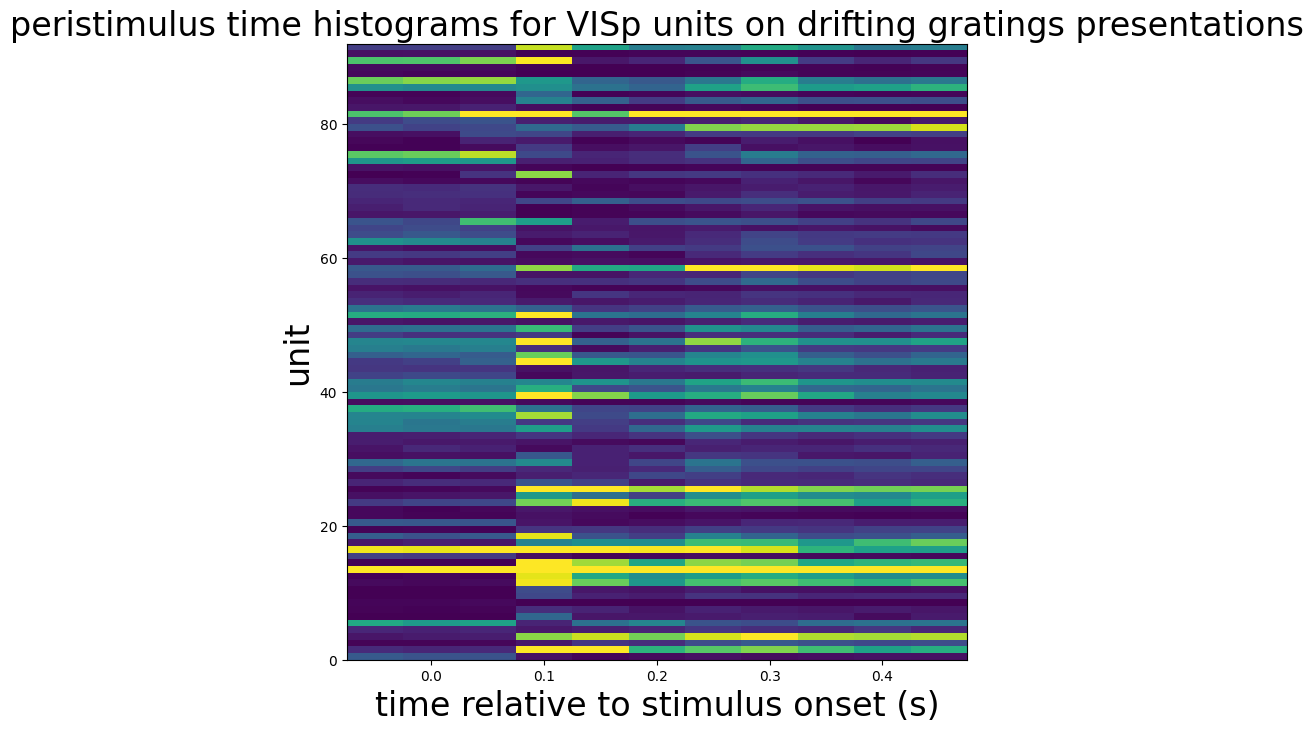

In [8]:
mean_histograms = histograms.mean(dim="stimulus_presentation_id")

fig, ax = plt.subplots(figsize=(8, 8))
ax.pcolormesh(
    mean_histograms["time_relative_to_stimulus_onset"], 
    np.arange(mean_histograms["unit_id"].size),
    mean_histograms.T, 
    vmin=0,
    vmax=1
)

ax.set_ylabel("unit", fontsize=24)
ax.set_xlabel("time relative to stimulus onset (s)", fontsize=24)
ax.set_title("peristimulus time histograms for VISp units on drifting gratings presentations", fontsize=24)

plt.show()

### Look at firing rate of specific neurons, split by grating orientation

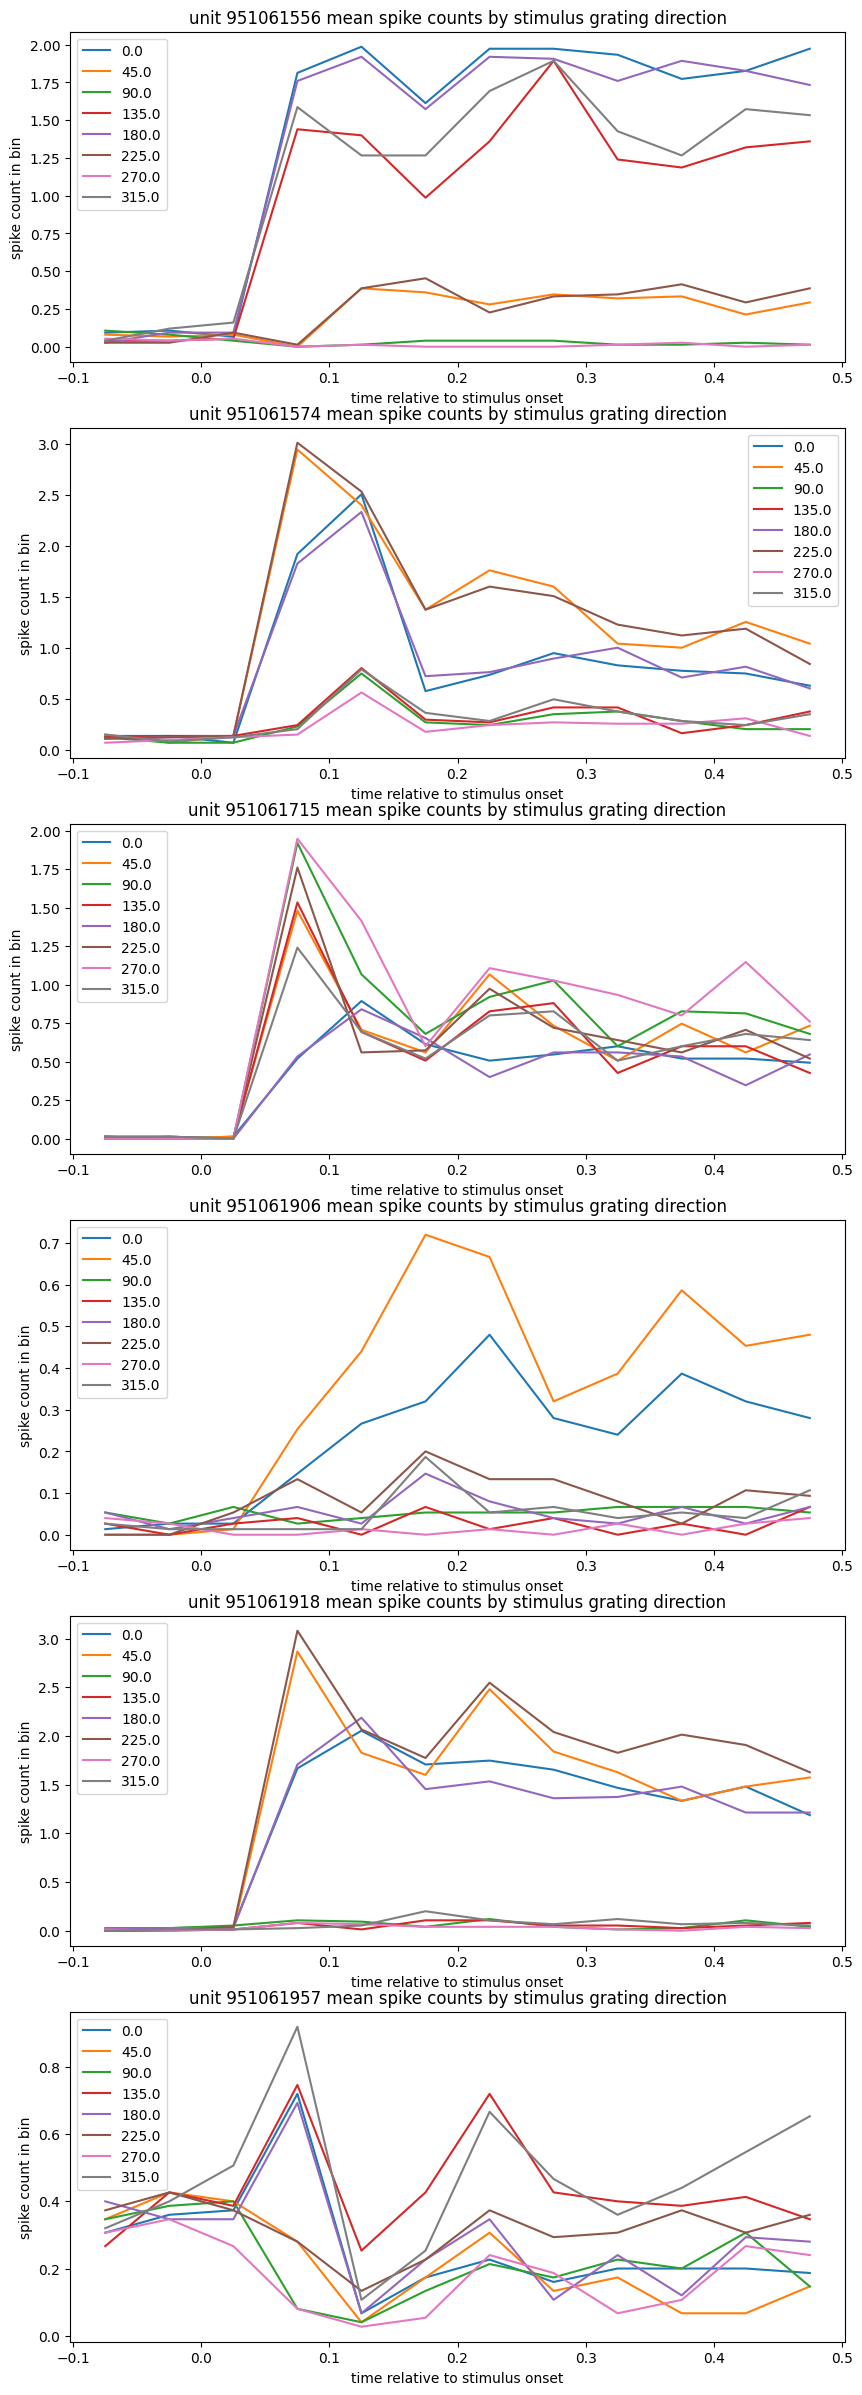

In [8]:
# for each unit, make plots of averaged responses across each orientation, aligned to stim onset

# a list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
fig, ax = plt.subplots(len(interesting_units), 1, figsize=(10, 30))

for i, unit_id in enumerate(interesting_units):
    for orientation in unique_orientations: 
        trial_ids = presentations[presentations.orientation == orientation].index.values        
        data = histograms.loc[trial_ids, :, unit_id]
        mean = data.mean(dim="stimulus_presentation_id")
        ax[i].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
    ax[i].legend()
    ax[i].set_xlabel("time relative to stimulus onset")
    ax[i].set_ylabel("spike count in bin")
    ax[i].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


### observation: direction selectivity, orientation selectivity
(TODO) coordinate with Day2 notebook

## Focus specifically on Unit 951061556
- Plot spike counts for each stim presentation, colored by orientation
- Appreciate that activity not only varies with stim and time, but also varies on the same stim presentation? 
- General question: how to explain variation in activity?

Text(0.5, 1.0, 'unit 951061556 mean spike counts by stimulus grating direction')

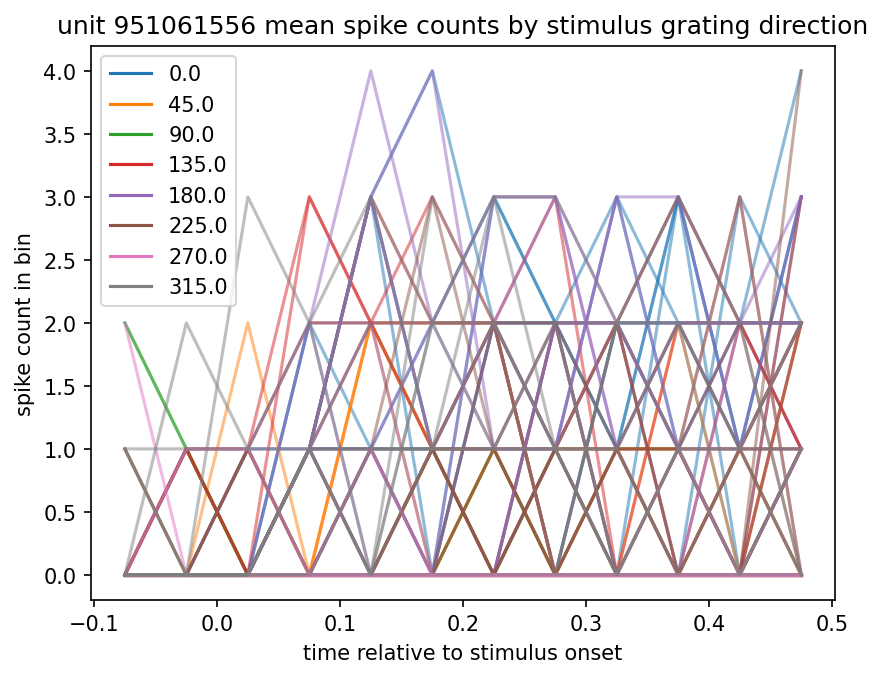

In [9]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(dpi=150)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

unit_id = 951061556
for i, orientation in enumerate(unique_orientations): 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    # plot 10 instances of this stim presentation
    color = colors[i]
    for trial in range(10):
        activity = data[trial, :]
        ax.plot(data["time_relative_to_stimulus_onset"], activity, c=color, alpha=0.5)
    ax.plot([], [], label=orientation, c=color)
ax.legend()
ax.set_xlabel("time relative to stimulus onset")
ax.set_ylabel("spike count in bin")
ax.set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")

## Prep for models: Divide data into train/test sets, define r^2 helper

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

presentations.index.values
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)

unit_id = 951061556
orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = histograms.loc[train_idxs, :, unit_id].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = histograms.loc[test_idxs, :, unit_id].values

def calc_r_squared(y_true, y_pred):
    """
    Calculates r^2 metric for true vs predicted labels
    NOTE: could also use .score() from sklearn LinearRegression here, but it's a bit unfitting since
    we'd want to evaluate r^2 for all time points, but are sometimes training different models for each time point. 
    Args: 
        y_true, y_pred of any shape
    """
    return 1 - np.sum((y_true - y_pred)**2) / np.sum(((y_true - y_true.mean()) ** 2))


## Let's look at how we can model neural dynamics

## Simplest stimulus-based regression. 
$$ r_t = w^{stim} \times s $$
Where r_t is neuron's activity, $ w^{stim} $ is learned weight, and s is stimulus direction

In [16]:
num_time_steps = spikes_train.shape[1]
X_train = orientations_train.repeat(num_time_steps).reshape(-1, 1)
Y_train = spikes_train.flatten()

X_test = orientations_test.repeat(num_time_steps).reshape(-1, 1)
Y_test = spikes_test.flatten()

reg = LinearRegression()
reg.fit(X_train, Y_train)

train_score = calc_r_squared(Y_train, reg.predict(X_train))
test_score = calc_r_squared(Y_test, reg.predict(X_test))
print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.0028229561546554427
Test Score: 0.0012846043025420695


low R^2 indicates that models without temporal informcation perform poorly on reconstructing the neural dynamics. Let's see if models with time-dependent weights improve the prediction

## Stimulus-based regression with varying weights
$$ r_t = w^{stim}_t \times s $$
In this case, training regression models separately per time point

### Train models

In [11]:
lin_reg_results = []

Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    reg = LinearRegression()
    X_train = orientations_train.reshape(-1, 1)
    Y_train = spikes_train[:, i]

    X_test = orientations_test.reshape(-1, 1)

    reg.fit(X_train, Y_train)

    lin_reg_results.append(reg)    
    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))


### Evaluate train and test scores

In [18]:
train_score = calc_r_squared(spikes_train, np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test, np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.12032055533298969
Test Score: 0.12097803963516807


We see a little improvement, as we have as many models/ parameters as the number of time bins.

### Visualize regression results, compare to per stim averaged by timebin

Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction')

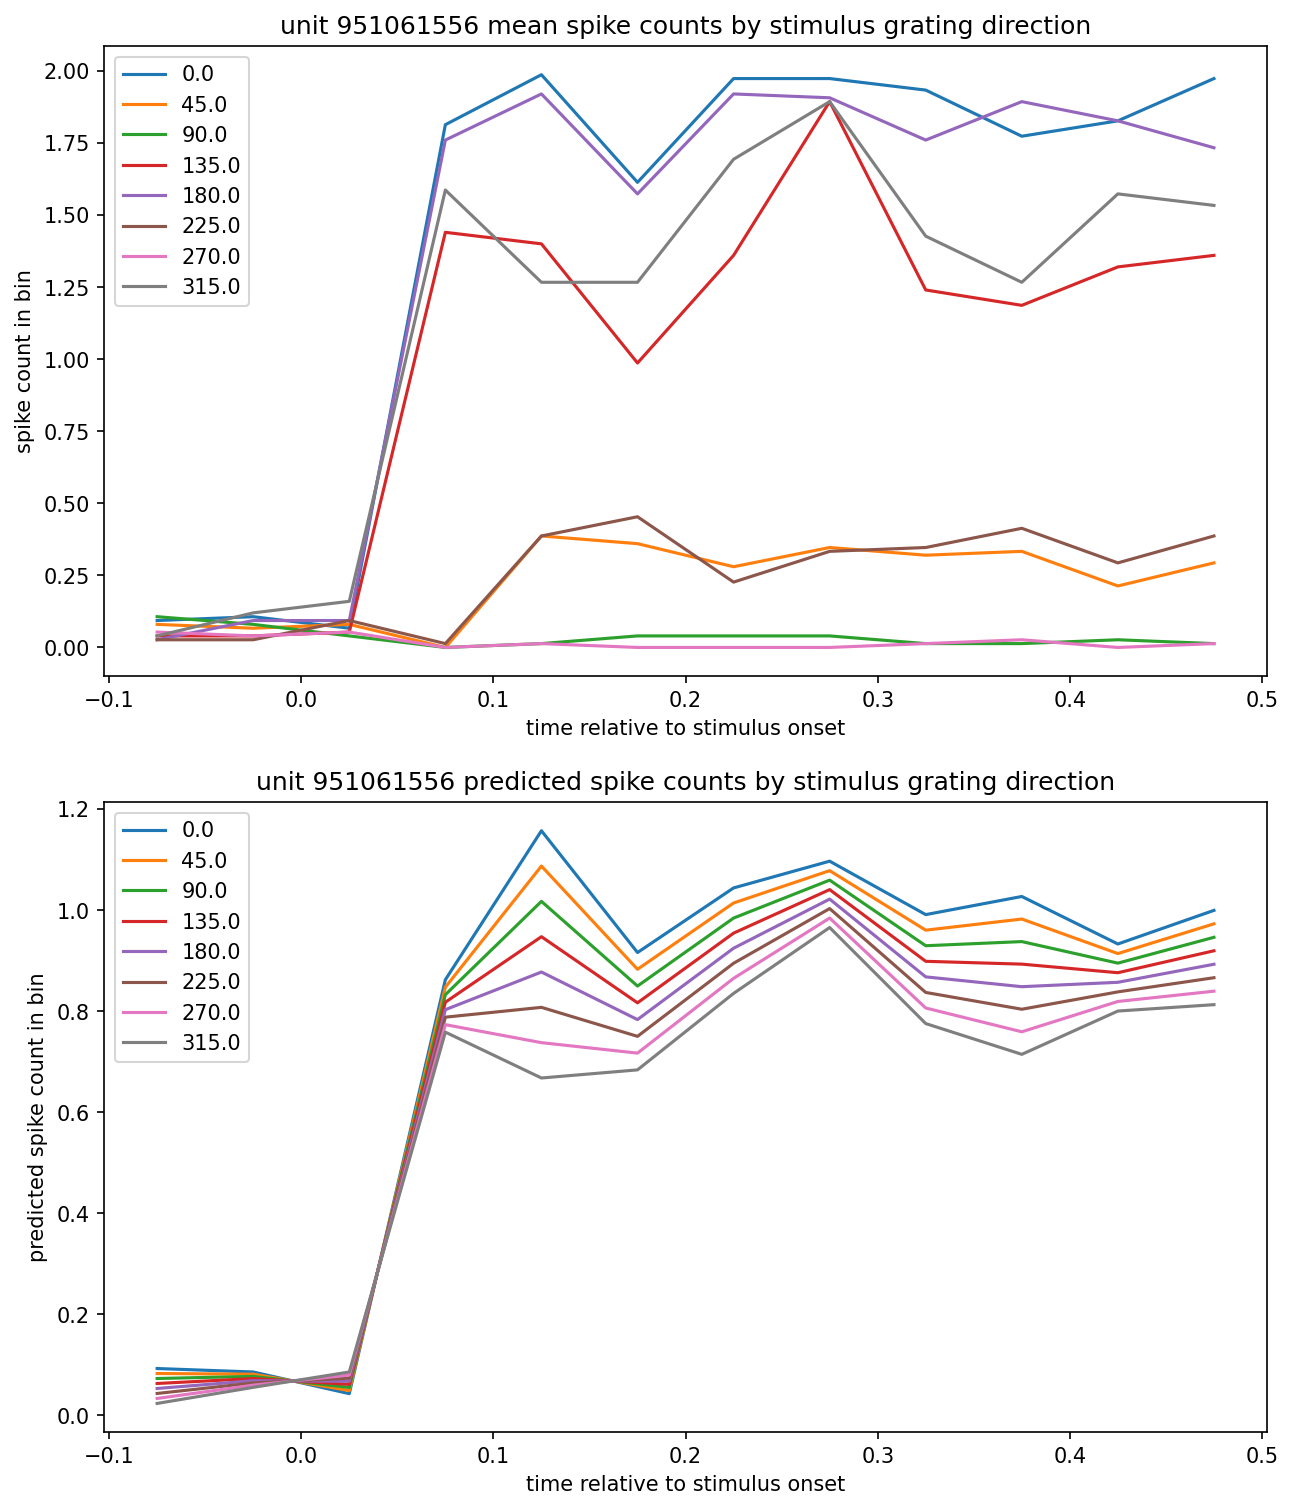

In [19]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

The unit shows strong orientation selectivity from the PSTH plot, but our model cannot capture the separation of orientation selecvtity. How can we improve the model?

## stimulus + 1 time bin back regression: auto-regressive model

$$ r_t = w^{stim}_t \times s + w^{auto}_{t} \times r_{t-1} $$

Per timestep, is variation in activity better explained by stim direction as well as previous activity?

In [16]:
def get_X_auto_reg(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.stack([orientations, spikes[:, i-1]]).T

auto_reg_results = []
Y_train_preds = []
Y_test_preds = []
for i in range(spikes_train.shape[1]):
    if i >= 1:
        reg = LinearRegression()
        X_train = get_X_auto_reg(spikes_train, orientations_train, i)
        X_test = get_X_auto_reg(spikes_test, orientations_test, i)

        Y_train = spikes_train[:, i]
        reg.fit(X_train, Y_train)
        auto_reg_results.append(reg)

        Y_train_preds.append(reg.predict(X_train))
        Y_test_preds.append(reg.predict(X_test))

In [17]:
train_score = calc_r_squared(spikes_train[:, 1:], np.vstack(Y_train_preds).T)
test_score = calc_r_squared(spikes_test[:, 1:], np.vstack(Y_test_preds).T)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.3796521752797779
Test Score: 0.35576335856532204


Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction + autoregression')

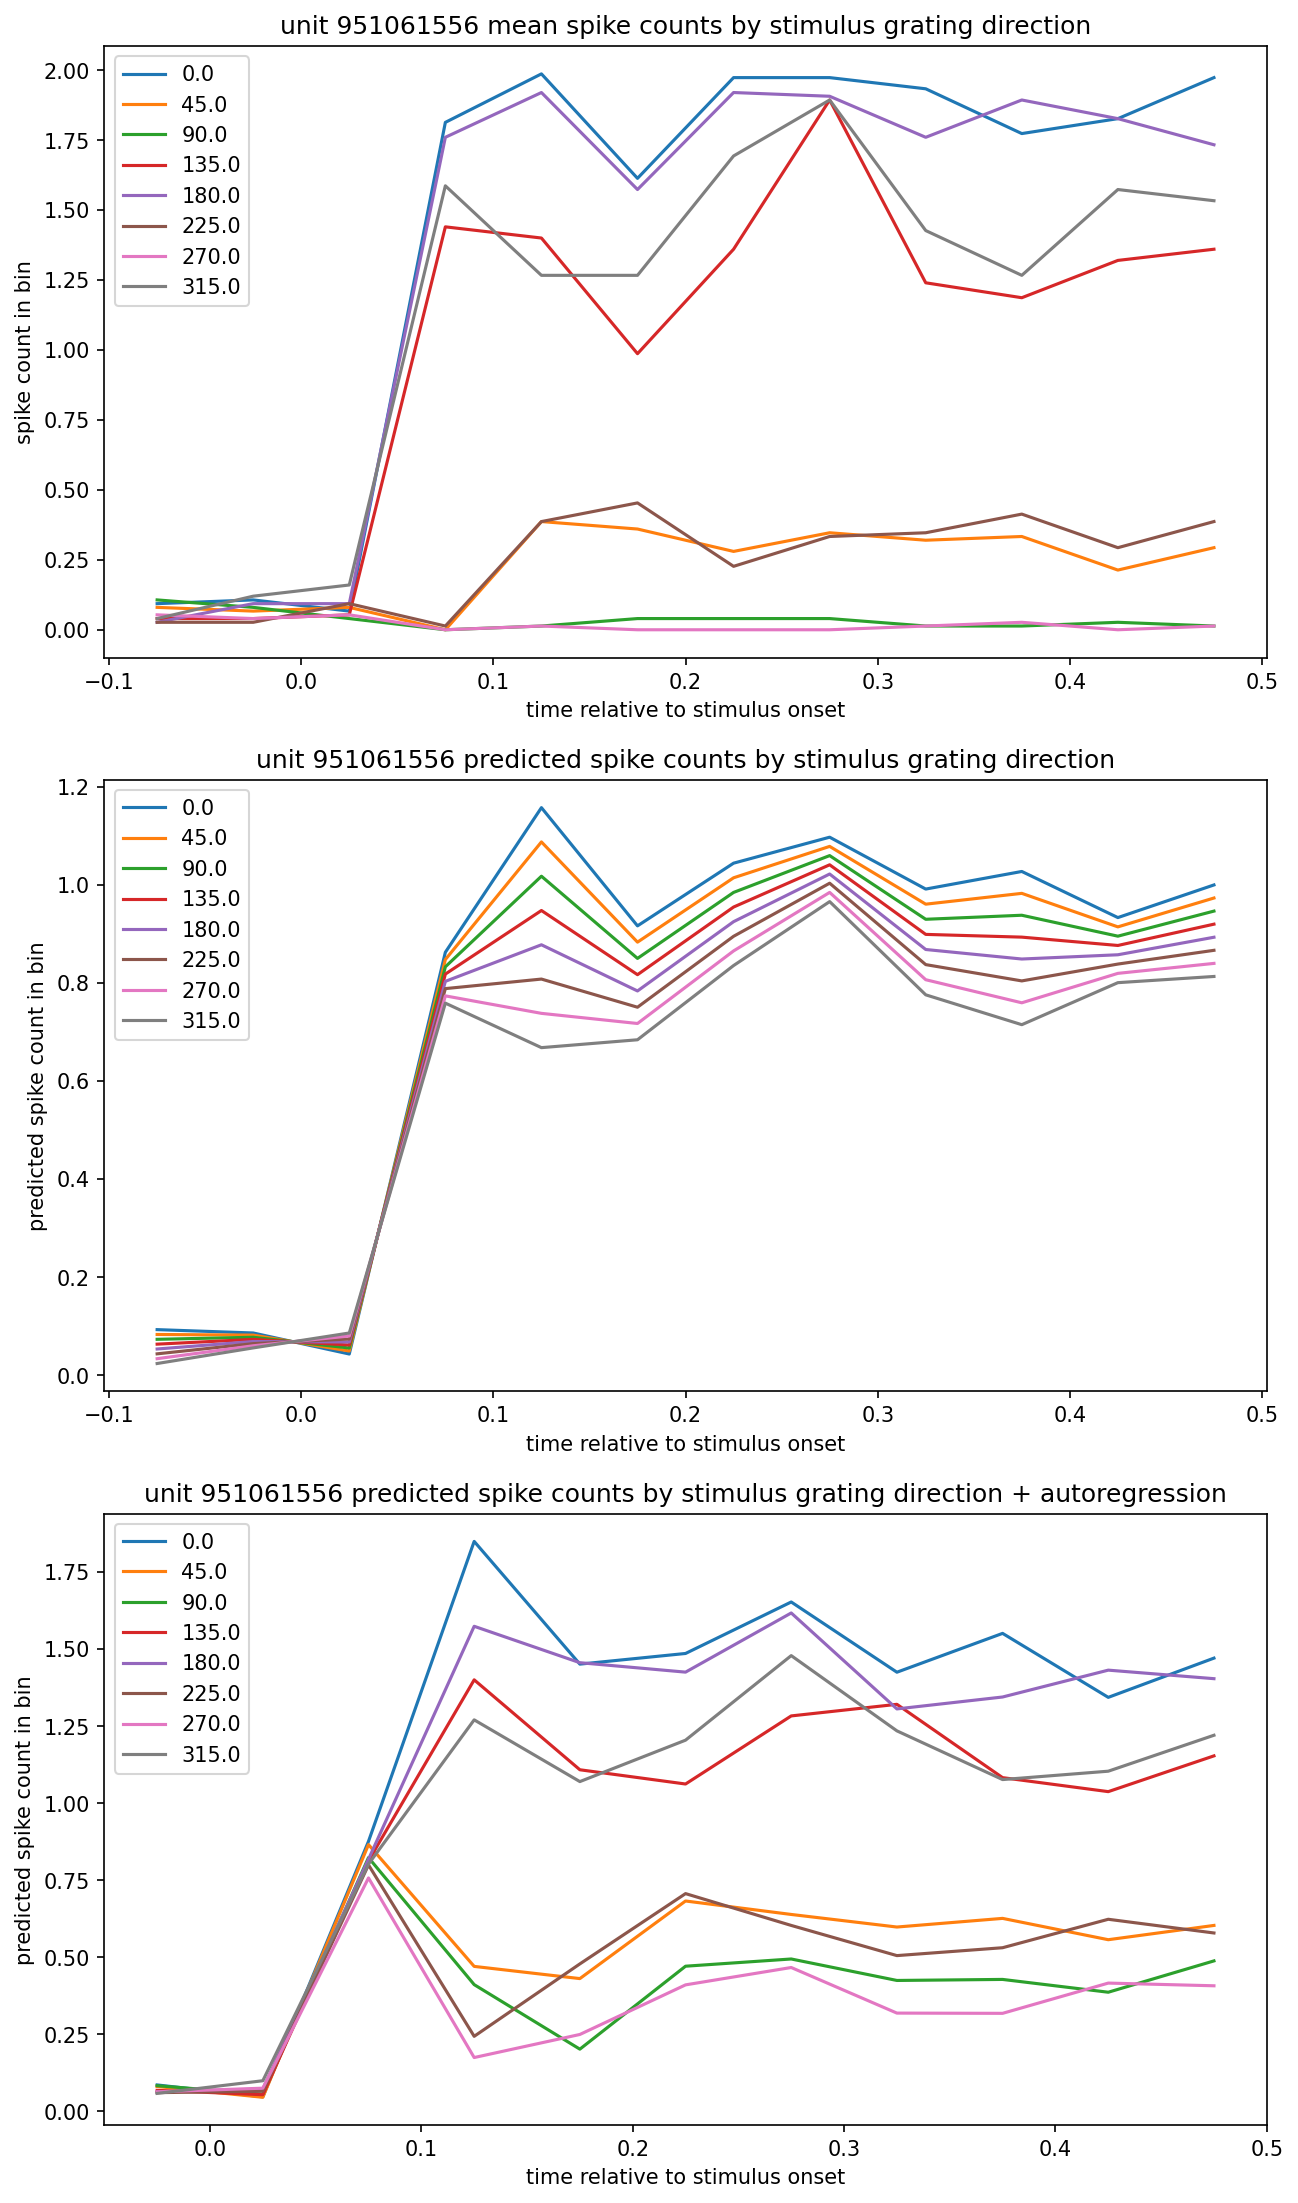

In [18]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), len(auto_reg_results)))
for i, res in enumerate(auto_reg_results):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = histograms.loc[trial_ids, :, unit_id]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg(data, orientations, time_bin_idx)
        Y = res.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression")

The history-dependent model shows orientation selectivity in the unit's activity. How far back from the history is contributing to the current activity?

## Same autoregressive model, but what if we added more lag?

$$ r_t = w^{stim}_t \times s + \sum_{l=1}^L w^{auto}_{t,l} \times r_{t-l} $$

How do scores vary with choice of lag $L$ we choose?

In [54]:
def get_X_auto_reg(spikes, orientations, i, T):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
        T: total lag
    """
    orientations = np.expand_dims(orientations, axis=1)
    return np.concatenate([orientations, spikes[:, i-T:i]], axis=1)

train_scores = []
test_scores = []
auto_reg_results = {}

for T in range(1, 10):
    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []
    for i in range(spikes_train.shape[1]):
        if i >= T:
            # should drop the first T bins?
            reg = LinearRegression()
            X_train = get_X_auto_reg(spikes_train, orientations_train, i, T)
            X_test = get_X_auto_reg(spikes_test, orientations_test, i, T)

            Y_train = spikes_train[:, i]
            reg.fit(X_train, Y_train)
            auto_reg_fits.append(reg)

            Y_train_preds.append(reg.predict(X_train))
            Y_test_preds.append(reg.predict(X_test))
    # evaluate bin index [T: )
    train_score = calc_r_squared(spikes_train[:, T:], np.vstack(Y_train_preds).T)
    test_score = calc_r_squared(spikes_test[:, T:], np.vstack(Y_test_preds).T)
    train_scores.append(train_score)
    test_scores.append(test_score)
    auto_reg_results[T] = auto_reg_fits

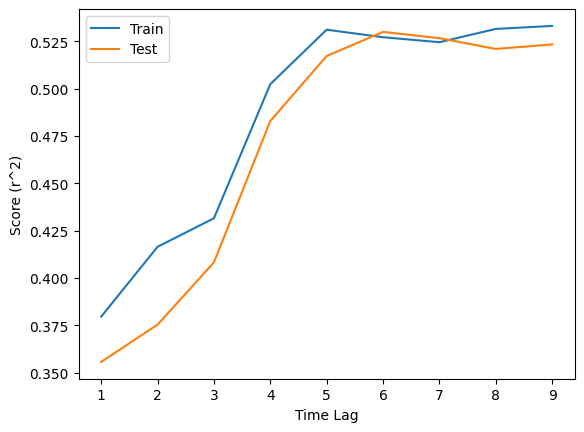

In [55]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), train_scores, label="Train")
ax.plot(range(1, 10), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score (r^2)")
ax.legend()

The score plateus at 5 time bin back, which is 250ms.

## How do auto-regressive coefficients change over the course of a trial?

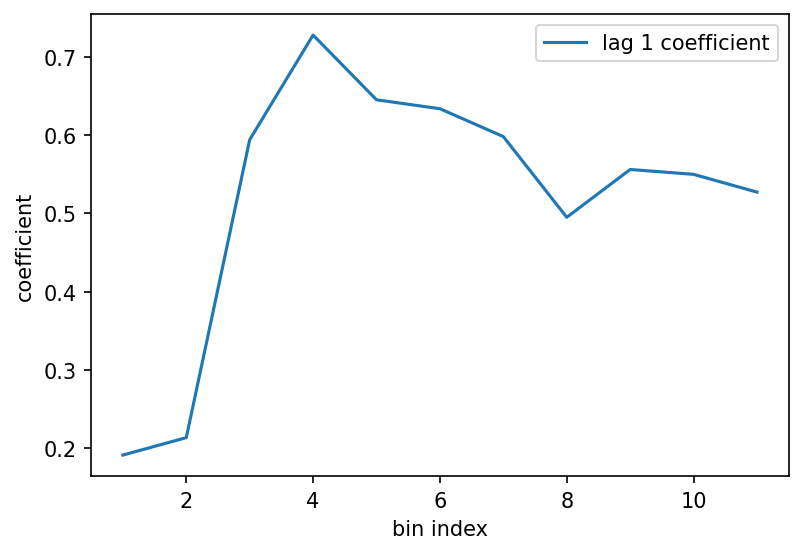

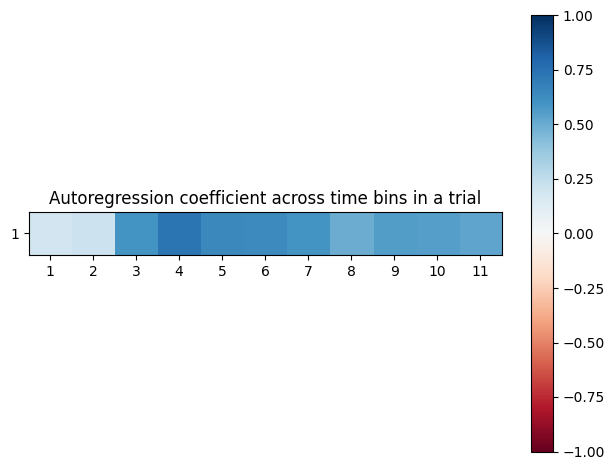

In [74]:
# use time_lag=1 model as an exmaple

lag_model = 1
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[1:])
reg_coeff = np.array(reg_coeff)

# plot
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j} coefficient')
ax.set_xlabel("bin index")
ax.set_ylabel("coefficient")
ax.legend()


fig, ax = plt.subplots()
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))
ax.set_title("Autoregression coefficient across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

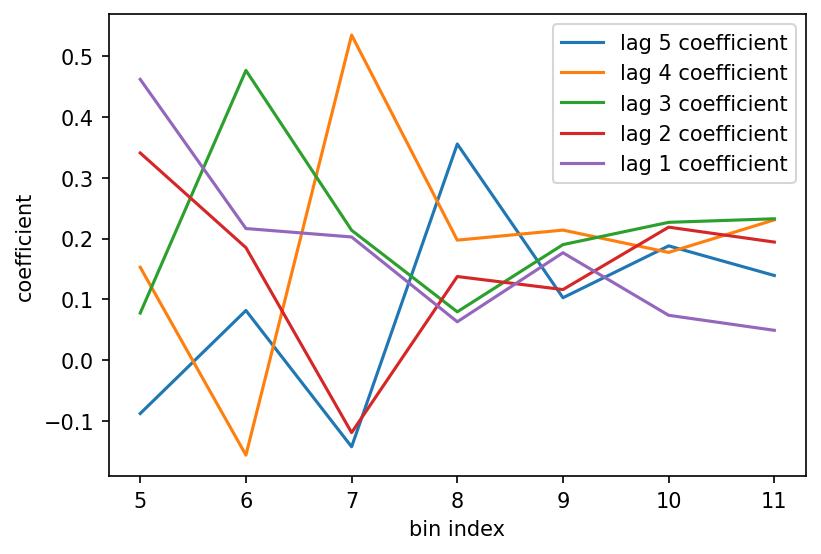

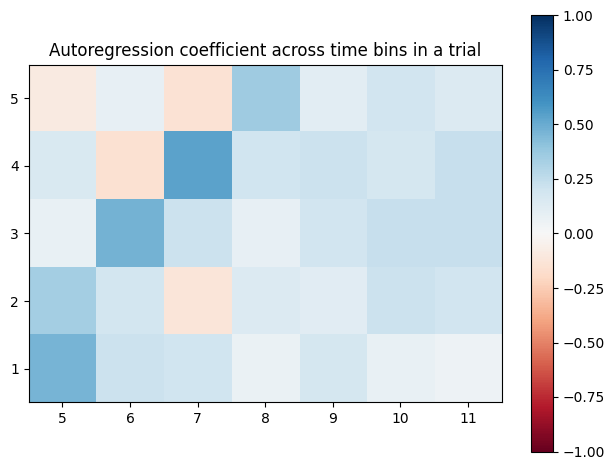

In [75]:
# use time_lag=5 model as an exmaple

lag_model = 5
reg_coeff = []
for i, reg in enumerate(auto_reg_results[lag_model]):
    reg_coeff.append(reg.coef_[1:])
reg_coeff = np.array(reg_coeff)

# plot
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
for j in range(reg_coeff.shape[1]):
    ax.plot(np.arange(lag_model, lag_model+reg_coeff.shape[0]), reg_coeff[:, j], 
            label=f'lag {lag_model-j} coefficient')
ax.set_xlabel("bin index")
ax.set_ylabel("coefficient")
ax.legend()


fig, ax = plt.subplots()
im = ax.imshow(reg_coeff.T, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(reg_coeff.shape[0]))
ax.set_xticklabels(np.arange(lag_model, lag_model+reg_coeff.shape[0]))
ax.set_yticks(np.arange(reg_coeff.shape[1]))
ax.set_yticklabels(np.arange(reg_coeff.shape[1], 0, -1))
ax.set_title("Autoregression coefficient across time bins in a trial")
fig.colorbar(im, ax=ax)
fig.tight_layout()

## Another auto regressive model: 
The plots above reveal that maybe we don't need to a separate model for each time point - we can introduce a set of shared weights (kernel) for the regressors (stimulus and past activity) for all the time points.
$$ r(t) = w^{stim} \times s(t) + \sum_{l=1}^{L_{auto}} w^{auto}_{l} \times r(t-l) = w^{stim} \times s(t) + \bm{w^{auto} \circledast} \bm{r} $$

### stimulus-based regression + autoregression with fixed weights across time bins

### stimulus + 1 time bin back

In [95]:
def get_X_auto_reg(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.stack([orientations, spikes[:, i-1]]).T

X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    if i >= 1:
        X_train_i = get_X_auto_reg(spikes_train, orientations_train, i)
        X_test_i = get_X_auto_reg(spikes_test, orientations_test, i)
        Y_train_i = spikes_train[:, i]
        Y_test_i = spikes_test[:, i]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.array(X_train).reshape(-1, 2)
X_test = np.array(X_test).reshape(-1, 2)
Y_train = np.array(Y_train).reshape(-1, 1)
Y_test = np.array(Y_test).reshape(-1, 1)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

In [96]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.3390309852961072
Test Score: 0.31961728527890965


Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction + autoregression, fixed weight')

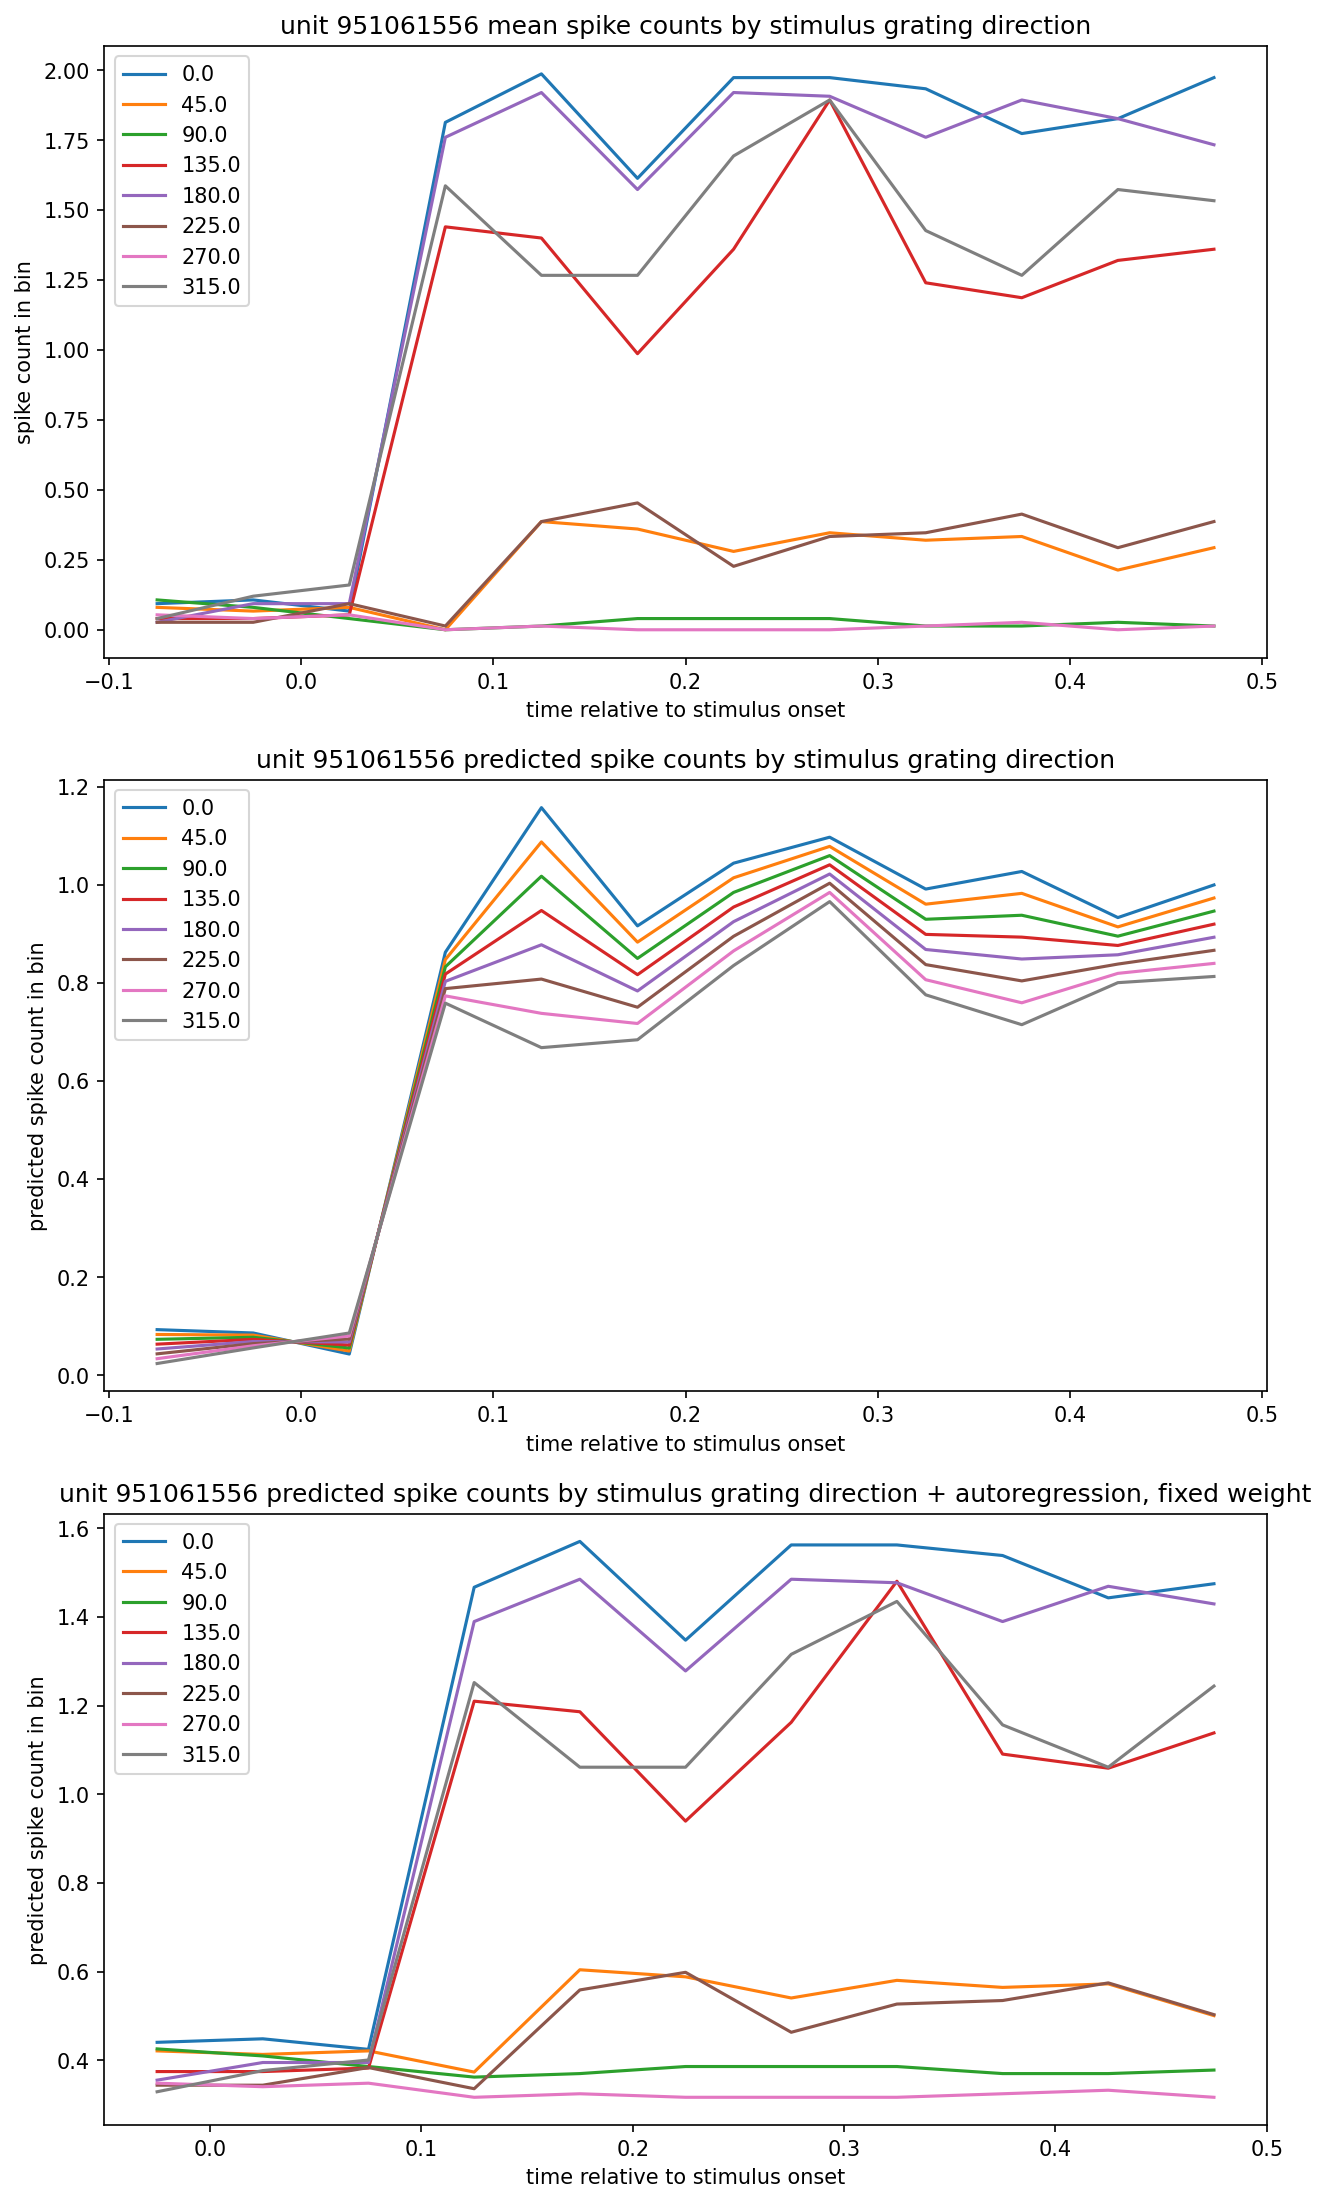

In [102]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), spikes_train.shape[1]-1))
for i in range(spikes_train.shape[1]-1):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = histograms.loc[trial_ids, :, unit_id]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg(data, orientations, time_bin_idx)
        Y = reg.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression, fixed weight")

Observation: the model with shared weights performs similarly well with time-varying weight models, and can capture the oreintation selectivity of this unit

### How far back to the history will influence the current activity

In [111]:
def get_X_auto_reg(spikes, orientations, i, T):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps
        orientations: data array of num_trials
        i: index of time bin
        T: total lag
    """
    orientations = np.expand_dims(orientations, axis=1)
    return np.concatenate([orientations, spikes[:, i-T:i]], axis=1)


auto_reg_fixed_weights_fits = []
train_scores = []
test_scores = []

for T in range(1, 10):
    print(f'fitting model of lag {T}')
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    auto_reg_fits = []
    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= T:
            X_train_i = get_X_auto_reg(spikes_train, orientations_train, i, T)
            X_test_i = get_X_auto_reg(spikes_test, orientations_test, i, T)
            Y_train_i = spikes_train[:, i]
            Y_test_i = spikes_test[:, i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, T+1)
    X_test = np.array(X_test).reshape(-1, T+1)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    auto_reg_fixed_weights_fits.append(reg)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    # evaluate bin index [T: )
    train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
    test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))
    train_scores.append(train_score)
    test_scores.append(test_score)

fitting model of lag 1
fitting model of lag 2
fitting model of lag 3
fitting model of lag 4
fitting model of lag 5
fitting model of lag 6
fitting model of lag 7
fitting model of lag 8
fitting model of lag 9


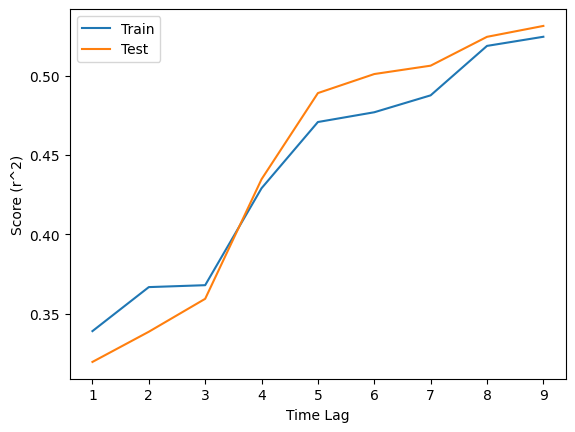

In [112]:
fig, ax = plt.subplots()
ax.plot(range(1, 10), train_scores, label="Train")
ax.plot(range(1, 10), test_scores, label="Test")
ax.set_xlabel("Time Lag")
ax.set_ylabel("Score (r^2)")
ax.legend()

Performance of the model with shared weights increases as we include more lags as regressors

### check regression coefficients
now let's take a look at what regression coefficients might tell us from the fixed weight model

In [120]:
model_lag = 1
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
print(f'lag-{model_lag} model coefficients')
print(f' {reg_model.coef_[0, 1:]}')

model_lag = 5
reg_model = auto_reg_fixed_weights_fits[model_lag-1]
print(f'lag-{model_lag} model coefficients')
print(f' {reg_model.coef_[0, 1:]}')

lag-1 model coefficients
 [0.59690098]
lag-5 model coefficients
 [0.00999872 0.14720429 0.19181358 0.21902063 0.28316707]


Observation: the coefficient decays as the lag goes back, indicating that the influence of past activity on present neural activity gradually decreases as time goes on.

## How can we examine the interaction among units and how it might contribute to neural dynamics?

# Models with activities from other neurons

$$ r_i(t) = w^{stim} \times s(t) + \sum_{j=1}^{N_{units}} w^{inter}_{ij} \times r_j(t-1)$$
assuming we only use lag-1 model here, as its influence is the strongest.

In [12]:
# using the list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
interesting_units = [
    951061556,
    951061574,
    951061715,
    951061906,
    951061918,
    951061957
]
target_unit_id = 951061556

presentations.index.values
random_state = 42 # ensure each run has the same split
train_idxs, test_idxs = train_test_split(presentations.index.values, test_size=0.2, random_state=random_state)

orientations_train = presentations.orientation.loc[train_idxs].values
spikes_train = histograms.loc[train_idxs, :, interesting_units].values

orientations_test = presentations.orientation.loc[test_idxs].values
spikes_test = histograms.loc[test_idxs, :, interesting_units].values

## stimulus + 1 time bin back

In [13]:
def get_X_auto_reg_population(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.concatenate([orientations[:, None], spikes[:, i-1, :]], axis=1)

X_train, Y_train = [], []
X_test, Y_test = [], []

Y_train_preds = []
Y_test_preds = []

for i in range(spikes_train.shape[1]):
    if i >= 1:
        X_train_i = get_X_auto_reg_population(spikes_train, orientations_train, i)
        X_test_i = get_X_auto_reg_population(spikes_test, orientations_test, i)
        Y_train_i = spikes_train[:, i, 0]
        Y_test_i = spikes_test[:, i, 0]

        X_train.append(X_train_i)
        X_test.append(X_test_i)
        Y_train.append(Y_train_i)
        Y_test.append(Y_test_i)

X_train = np.array(X_train).reshape(-1, len(interesting_units)+1)
X_test = np.array(X_test).reshape(-1, len(interesting_units)+1)
Y_train = np.array(Y_train).reshape(-1, 1)
Y_test = np.array(Y_test).reshape(-1, 1)

print(X_train.shape)
print(Y_train.shape)

reg = LinearRegression()
reg.fit(X_train, Y_train)

Y_train_preds.append(reg.predict(X_train))
Y_test_preds.append(reg.predict(X_test))

(5280, 7)
(5280, 1)


In [14]:
train_score = calc_r_squared(Y_train, np.vstack(Y_train_preds))
test_score = calc_r_squared(Y_test, np.vstack(Y_test_preds))

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.3500153671455981
Test Score: 0.32612600316033336


Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction + autoregression + population, fixed weight')

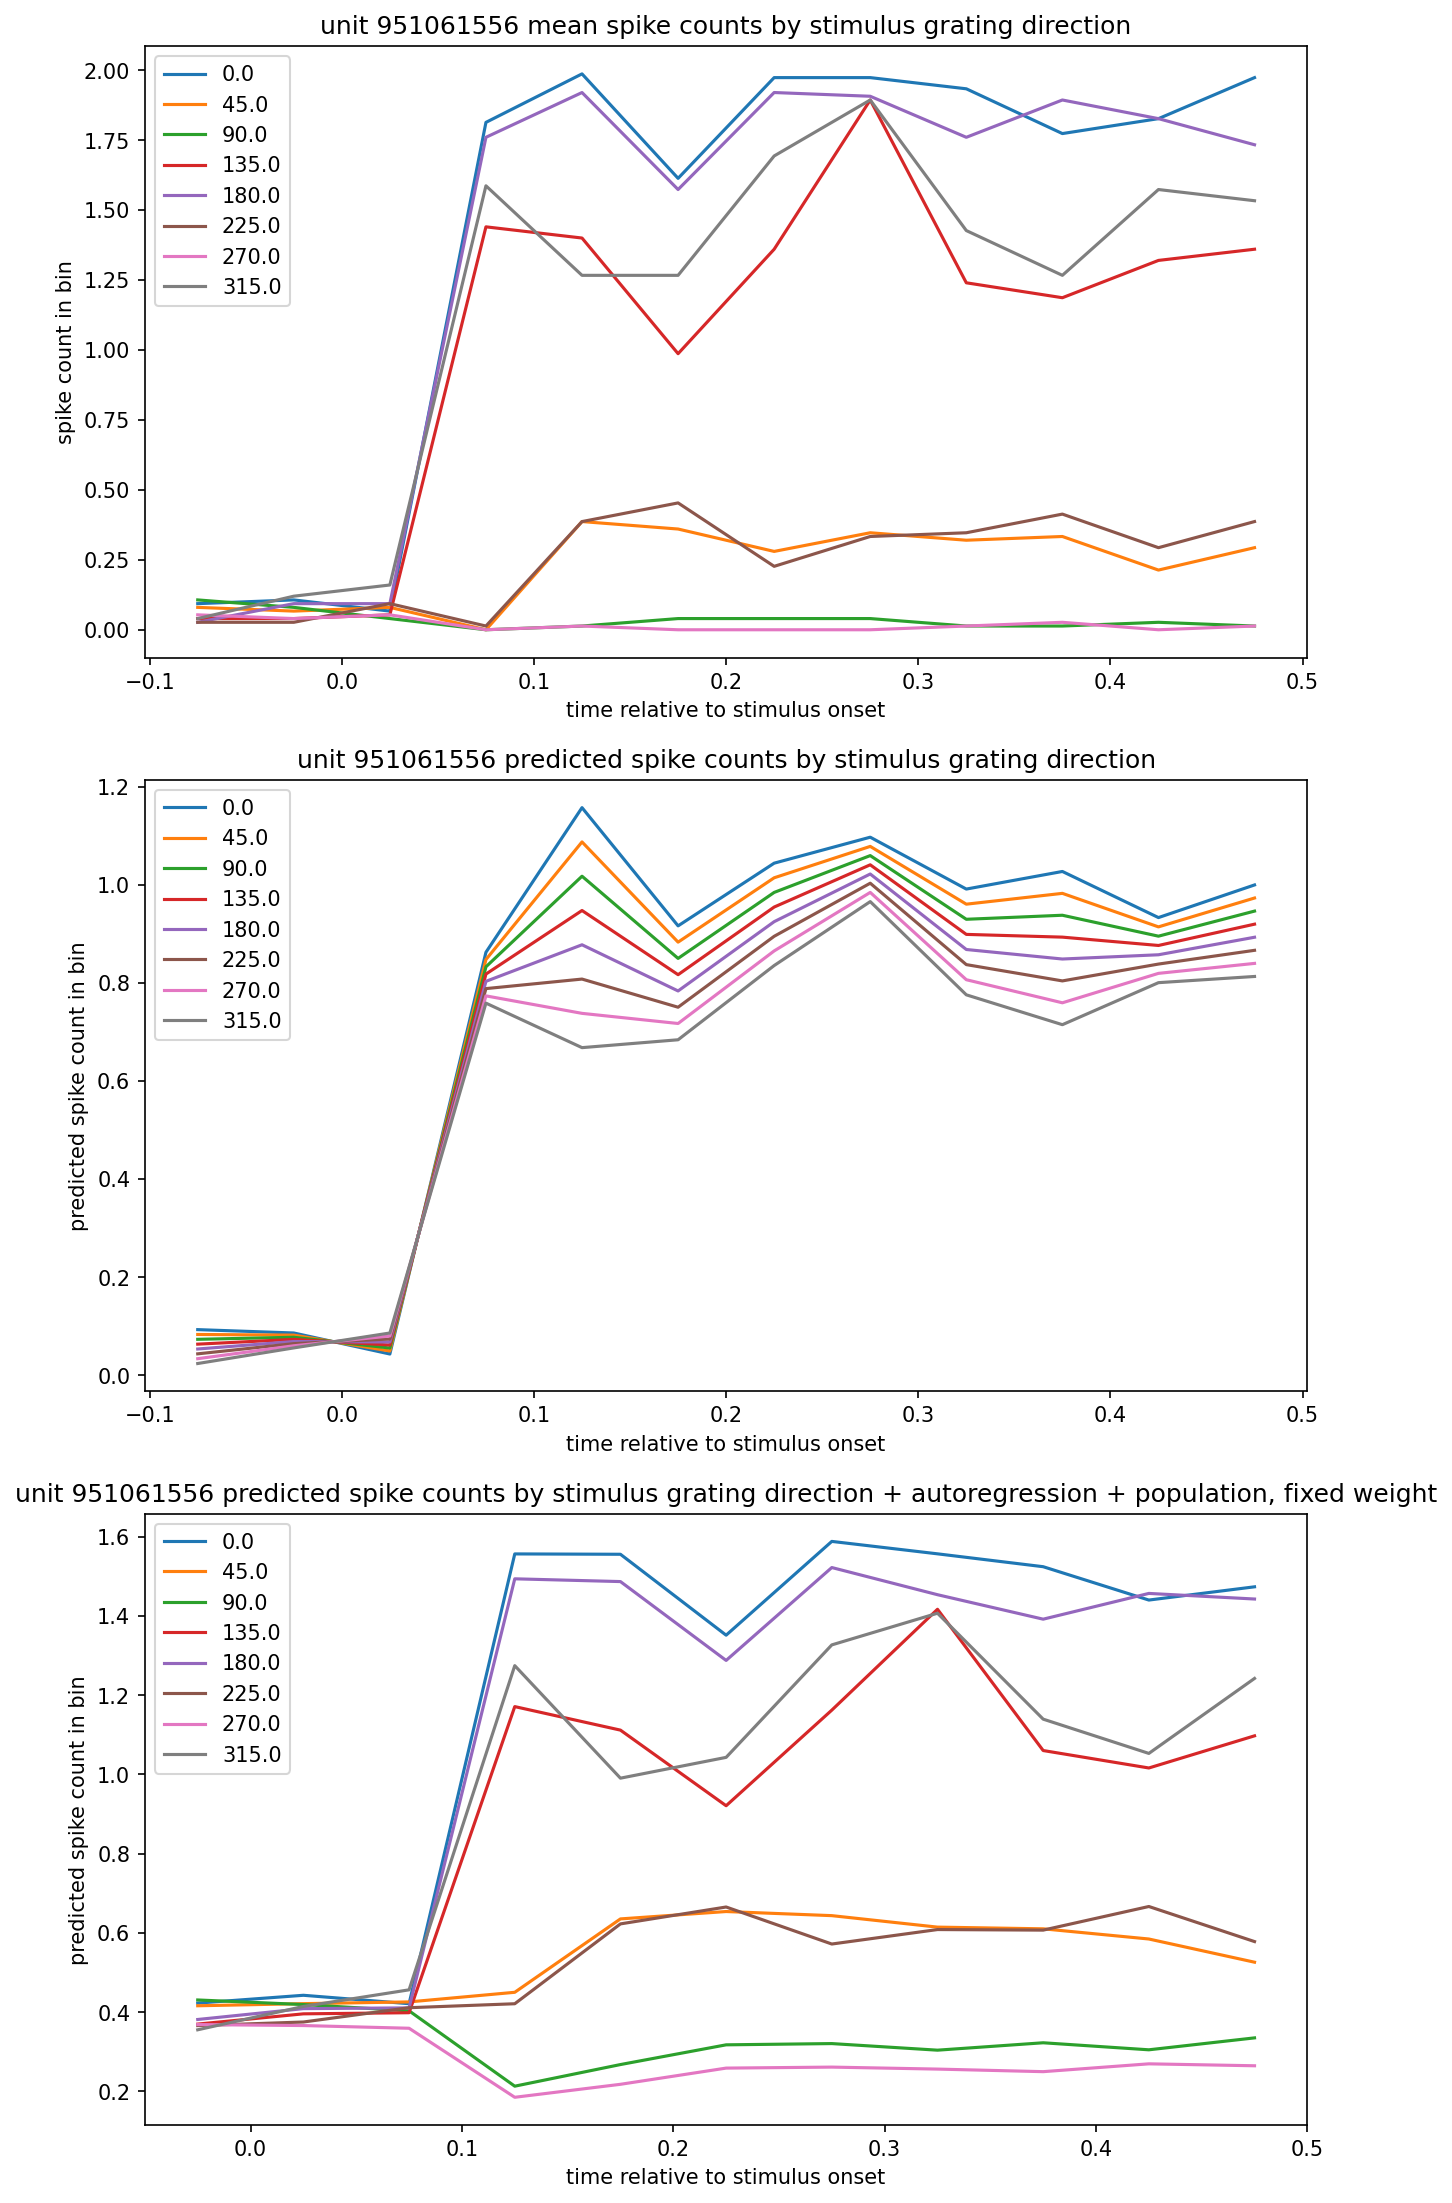

In [15]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(3, 1, figsize=(10, 18), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


# stimulus-based regression
pred_responses = []
for res in lin_reg_results:
    pred_responses.append(res.predict(unique_orientations.reshape(-1,1)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")

# plot auto regressive model means
pred_mean_responses = np.empty((len(unique_orientations), spikes_train.shape[1]-1))
for i in range(spikes_train.shape[1]-1):
    time_bin_idx = i + 1
    for j, orientation in enumerate(unique_orientations):
        trial_ids = presentations[presentations.orientation == orientation].index.values     
        orientations = np.repeat(orientation, len(trial_ids))
        data = histograms.loc[trial_ids, :, interesting_units]
        # X = np.stack([unique_orientations, pred_responses[-1]]).T
        X = get_X_auto_reg_population(data, orientations, time_bin_idx)
        Y = reg.predict(X)
        pred_mean_responses[j, i] = np.mean(Y)

for j, orientation in enumerate(unique_orientations):
    ax[2].plot(data["time_relative_to_stimulus_onset"][1:], pred_mean_responses[j, :], label=orientation)
ax[2].legend()
ax[2].set_xlabel("time relative to stimulus onset")
ax[2].set_ylabel("predicted spike count in bin")
ax[2].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction + autoregression + population, fixed weight")

### Examine influence from other neurons

In [16]:
print(f'target_unit: {target_unit_id}')
for i, unit in enumerate(interesting_units):
    print(f' unit {unit} coeff: {reg.coef_[0, i+1]}')


target_unit: 951061556
 unit 951061556 coeff: 0.5756899598723372
 unit 951061574 coeff: 0.005059117773624333
 unit 951061715 coeff: -0.059447431971149815
 unit 951061906 coeff: 0.07031319059286004
 unit 951061918 coeff: 0.05136750903213633
 unit 951061957 coeff: 0.1679648885438938


Observation: 
- dependence on self previous activity is the strongest (weight 0.58).
- some unit exerts excitatory effect: positive weight
- some unit might exert inhibitory effect: negative weight

## Population prediction
let's look at multiple neurons at the same time.

In [57]:
def get_X_auto_reg_population(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.concatenate([orientations[:, None], spikes[:, i-1, :]], axis=1)


X_train_dict, Y_train_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}
reg_dict = {}
Y_train_preds_dict = {}
Y_test_preds_dict = {}


for unit_i, unit in enumerate(interesting_units):
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= 1:
            X_train_i = get_X_auto_reg_population(spikes_train, orientations_train, i)
            X_test_i = get_X_auto_reg_population(spikes_test, orientations_test, i)
            Y_train_i = spikes_train[:, i, unit_i]
            Y_test_i = spikes_test[:, i, unit_i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, len(interesting_units)+1)
    X_test = np.array(X_test).reshape(-1, len(interesting_units)+1)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    X_train_dict[unit] = X_train
    Y_train_dict[unit] = Y_train
    X_test_dict[unit] = X_test
    Y_test_dict[unit] = Y_test
    reg_dict[unit] = reg
    Y_train_preds_dict[unit] = Y_train_preds
    Y_test_preds_dict[unit] = Y_test_preds


In [ ]:
for unit in interesting_units:
    print(f'target_unit: {unit}')
    for i, unit_coeff in enumerate(interesting_units):
        print(f' unit {unit_coeff} coeff: {reg_dict[unit].coef_[0, i+1]}')

target_unit: 951061556
target_unit: 951061574
target_unit: 951061715
target_unit: 951061906
target_unit: 951061918
target_unit: 951061957


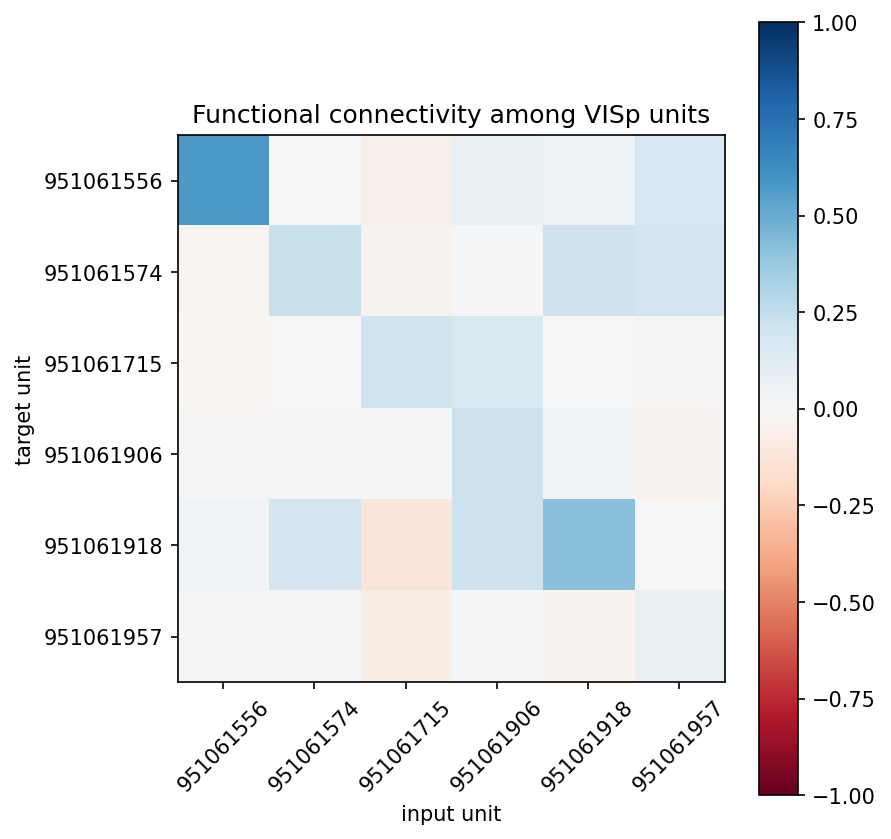

In [58]:
# get functional connectivity matrix
func_conn = []
for unit in interesting_units:
    print(f'target_unit: {unit}')
    func_conn.append(reg_dict[unit].coef_[0, 1:])
func_conn = np.array(func_conn)


fig, ax = plt.subplots(figsize=(6,6), dpi=150)
im = ax.imshow(func_conn, cmap='RdBu', vmin=-1, vmax=1)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(interesting_units)))
ax.set_xticklabels(interesting_units, rotation=45)
ax.set_yticks(np.arange(len(interesting_units)))
ax.set_yticklabels(interesting_units)
ax.set_xlabel('input unit')
ax.set_ylabel('target unit')
ax.set_title("Functional connectivity among VISp units")
fig.colorbar(im, ax=ax)
fig.tight_layout()

Observation: 
- diagonal elements are strongly positive, indicating self recurrent effect. 
- unit 951061715 might be an inhibitory unit as its effect on most other units are negative.

## with other brain regions
we can include units from other regions to examine potential interactions among different brain regions.
Here let's use units from the primary visual cortex (VISp) and its upstream area, the lateral geniculate nuclues (LGd), as an example to examine how interaction among units from different brain regions might contibute to neural activity patterns.

In [33]:
units_LGd = session.units[session.units["ecephys_structure_acronym"] == 'LGd']
unit_id_LGd = units_LGd.index.to_list()

histograms_LGd = session.presentationwise_spike_counts(
    stimulus_presentation_ids=presentations.index.values,  
    bin_edges=time_bins,
    unit_ids=unit_id_LGd
)

In [40]:
# using the list of interesting units predetermined by looking data/patrick_scratch/unit_frs_analysis figures
spikes_train_with_LGd = np.concatenate([histograms.loc[train_idxs, :, interesting_units].values,
                                        histograms_LGd.loc[train_idxs, :, unit_id_LGd].values], axis=2)

spikes_test_with_LGd = np.concatenate([histograms.loc[test_idxs, :, interesting_units].values,
                                       histograms_LGd.loc[test_idxs, :, unit_id_LGd].values], axis=2)

In [42]:
def get_X_auto_reg_population(spikes, orientations, i):
    """
    Generates a input data matrix for the 1 time bin auto regressive model
    Args:
        spikes: data array of num_trials x time steps x num_units
        orientations: data array of num_trials
        i: index of time bin
    """
    return np.concatenate([orientations[:, None], spikes[:, i-1, :]], axis=1)


X_train_dict, Y_train_dict = {}, {}
X_test_dict, Y_test_dict = {}, {}
reg_dict = {}
Y_train_preds_dict = {}
Y_test_preds_dict = {}

total_unit = interesting_units+unit_id_LGd

for unit_i, unit in enumerate(total_unit):
    X_train, Y_train = [], []
    X_test, Y_test = [], []

    Y_train_preds = []
    Y_test_preds = []

    for i in range(spikes_train.shape[1]):
        if i >= 1:
            X_train_i = get_X_auto_reg_population(spikes_train_with_LGd, orientations_train, i)
            X_test_i = get_X_auto_reg_population(spikes_test_with_LGd, orientations_test, i)
            Y_train_i = spikes_train_with_LGd[:, i, unit_i]
            Y_test_i = spikes_test_with_LGd[:, i, unit_i]

            X_train.append(X_train_i)
            X_test.append(X_test_i)
            Y_train.append(Y_train_i)
            Y_test.append(Y_test_i)

    X_train = np.array(X_train).reshape(-1, len(total_unit)+1)
    X_test = np.array(X_test).reshape(-1, len(total_unit)+1)
    Y_train = np.array(Y_train).reshape(-1, 1)
    Y_test = np.array(Y_test).reshape(-1, 1)

    reg = LinearRegression()
    reg.fit(X_train, Y_train)

    Y_train_preds.append(reg.predict(X_train))
    Y_test_preds.append(reg.predict(X_test))

    X_train_dict[unit] = X_train
    Y_train_dict[unit] = Y_train
    X_test_dict[unit] = X_test
    Y_test_dict[unit] = Y_test
    reg_dict[unit] = reg
    Y_train_preds_dict[unit] = Y_train_preds
    Y_test_preds_dict[unit] = Y_test_preds


target_unit: 951061556
target_unit: 951061574
target_unit: 951061715
target_unit: 951061906
target_unit: 951061918
target_unit: 951061957
target_unit: 951060149
target_unit: 951060126
target_unit: 951060091
target_unit: 951060134
target_unit: 951060162
target_unit: 951060157
target_unit: 951060187
target_unit: 951060191


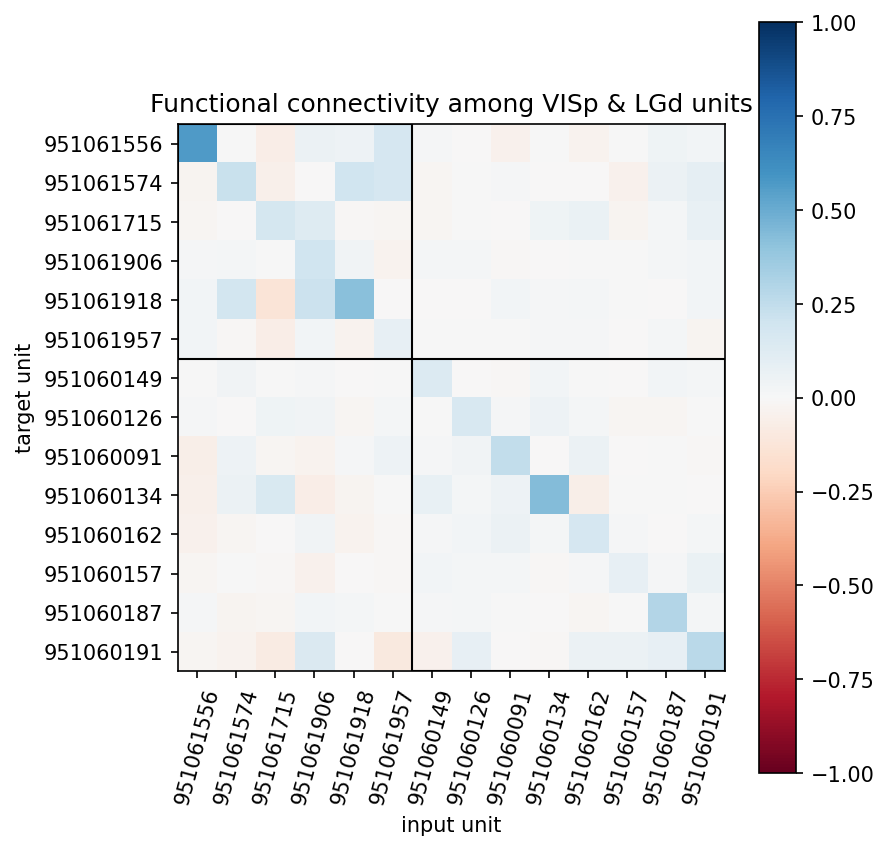

In [54]:
# get functional connectivity matrix
func_conn = []
for unit in total_unit:
    print(f'target_unit: {unit}')
    func_conn.append(reg_dict[unit].coef_[0, 1:])
func_conn = np.array(func_conn)

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(6,6), dpi=150)
im = ax.imshow(func_conn, cmap='RdBu', vmin=-1, vmax=1)
ax.add_patch(Rectangle((-0.5, -0.5), len(interesting_units), len(interesting_units), 
             edgecolor='black', facecolor='red', fill=False, lw=1))
ax.add_patch(Rectangle((-0.5+len(interesting_units), -0.5+len(interesting_units)), 
                    len(unit_id_LGd), len(unit_id_LGd), 
             edgecolor='black', facecolor='red', fill=False, lw=1))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(total_unit)))
ax.set_xticklabels(total_unit, rotation=75)
ax.set_yticks(np.arange(len(total_unit)))
ax.set_yticklabels(total_unit)
ax.set_xlabel('input unit')
ax.set_ylabel('target unit')
ax.set_title("Functional connectivity among VISp & LGd units")
fig.colorbar(im, ax=ax)
fig.tight_layout()

Observation
- Again, digonal elements indicate strong autocorrelation of neural activity
- in general the weights from VISp to LGd is more negative (the lower left quadrant), perhaps indicating the top-down feedback inhibition from VISp to LGd?

# Problem Sets

1. Adding nonlinearity: regression with sine/ cosine function of orientation
2. Adding nonlinearity: Generalized linear models
3. Dynamical mode decomposition
4. Recurrent neural network models

### Re-run linear regression with sine/cosine features
Note: we run into a bit of issue here since the stim traditionally is expressed in degrees (0, 45, 90 etc.) However, since we're introducing a time component, it'd make sense to differentiate when the stim is on vs. off, as well as the direction of the stim. Just using degrees doesn't allow us to do this, since 0 degrees != stim-off. One idea would be to translate the stim degrees as x,y cosine and sine components, and have x=0,y=0 indicate stim-off. 

In [ ]:
def get_sines_cosines_from_orientations(orientations):
    """
    Takes in orientations as degrees
    returns sines and cosines as np array of dims data_points x 2
    """
    radians = orientations.astype(float) * np.pi / 180
    sines = np.sin(radians)
    cosines = np.cos(radians)
    return np.vstack([cosines, sines]).T


In [ ]:
sines = np.sin(radians)
cosines = np.cos(radians)
X = np.vstack([cosines, sines]).T

In [ ]:
sin_cos_results = []
for i in range(spikes.shape[1]):
    reg = LinearRegression()
    X = get_sines_cosines_from_orientations(orientations)
    Y = spikes[:, i]
    reg.fit(X, Y)
    sin_cos_results.append(reg)

Text(0.5, 1.0, 'unit 951061556 predicted spike counts by stimulus grating direction')

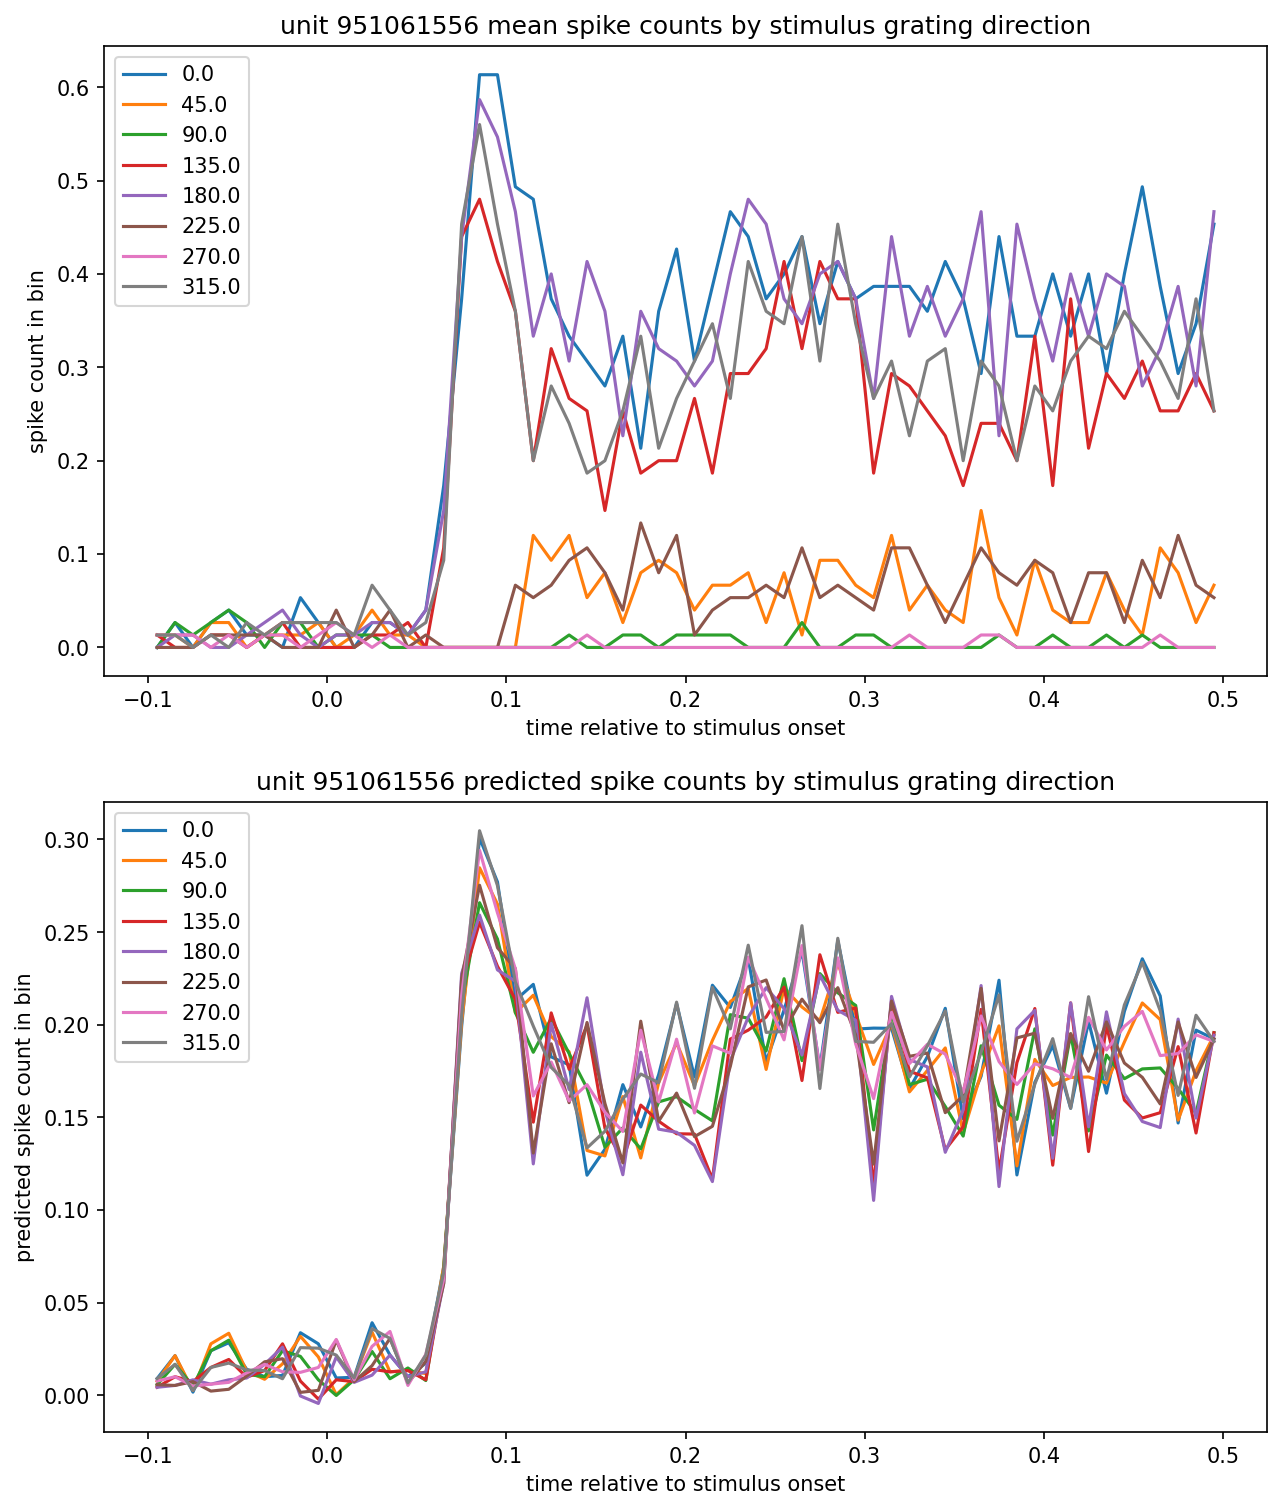

In [ ]:
# plot regression result
unique_orientations.sort()

fig, ax = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

unit_id = 951061556
for orientation in unique_orientations: 
    trial_ids = presentations[presentations.orientation == orientation].index.values        
    data = histograms.loc[trial_ids, :, unit_id]
    mean = data.mean(dim="stimulus_presentation_id")
    ax[0].plot(data["time_relative_to_stimulus_onset"], mean, label=orientation)
ax[0].legend()
ax[0].set_xlabel("time relative to stimulus onset")
ax[0].set_ylabel("spike count in bin")
ax[0].set_title(f"unit {unit_id} mean spike counts by stimulus grating direction")


pred_responses = []
for res in sin_cos_results:
    pred_responses.append(res.predict(get_sines_cosines_from_orientations(unique_orientations)))
pred_responses = np.array(pred_responses)

for i, orientation in enumerate(unique_orientations):
    ax[1].plot(data["time_relative_to_stimulus_onset"], pred_responses[:, i], label=orientation)
ax[1].legend()
ax[1].set_xlabel("time relative to stimulus onset")
ax[1].set_ylabel("predicted spike count in bin")
ax[1].set_title(f"unit {unit_id} predicted spike counts by stimulus grating direction")